In [1]:
import numpy as np 
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.ndimage import binary_dilation

from glob import glob
from os import path

from sibylla_lite import UVNonUniform


from jax.config import config
config.update("jax_enable_x64", True)

def nanargmax(a):
    idx = np.argmax(a, axis=None)
    multi_idx = np.unravel_index(idx, a.shape)
    if np.isnan(a[multi_idx]):
        nan_count = np.sum(np.isnan(a))
        # In numpy < 1.8 use idx = np.argsort(a, axis=None)[-nan_count-1]
        idx = np.argpartition(a, -nan_count-1, axis=None)[-nan_count-1]
        multi_idx = np.unravel_index(idx, a.shape)
    return multi_idx

def get_centre(a):
    args = np.array(np.unravel_index(nanargmax(a), np.array(a).shape)[1])[::-1]
    return args

def integer_recentre(a):
    dx, dy = get_centre(a)-np.array(a.shape)//2
    a = np.roll(np.roll(a, -int(round(dx)), axis=1),
                -int(round(dy)), axis=0)
    return a

def linear_fit(a,b):
    a = a.flatten()
    b = b.flatten()
    mask = np.logical_and(np.logical_and(np.isfinite(a), np.isfinite(b)), a>0)
    a = a[mask]
    b = b[mask]
    A = np.vstack([a, np.ones(len(a))]).T
    m, c = np.linalg.lstsq(A, b, rcond=None)[0]
    return m, c

def threshold_mask(a,dilation=0,thresh=99):
    bright_pixels = np.where(a>np.nanpercentile(a, thresh))
    mask = np.zeros_like(a)
    mask[bright_pixels] = 1
    if dilation>0:
        mask = binary_dilation(mask, iterations=dilation)
    return mask.astype('bool')

In [2]:
cd /Users/benpope/Downloads/MAST_2023-11-01T1130/JWST

/Users/benpope/Downloads/MAST_2023-11-01T1130/JWST


In [3]:
directories = glob('*')

for directory in directories:
    fnames = glob(directory + '/*_cal.fits')
    if fnames is not []:
        for fname in fnames:
            header = fits.getheader(fname)
            name = header['TARGNAME']
            obsnum = header['OBSERVTN']
            visit = header['VISIT']
            visit_group = header['VISITGRP']
            sequence = header['SEQ_ID']
            activity = header['ACT_ID']
            filter = header['FILTER']
            exposure = header['EXPOSURE']
            if 'Hor' in name:
                print(path.basename(fname).strip('_nis_cal.fits'),':', name.strip('*').strip(' ').replace('.',''), filter, 
                    visit_group, sequence, activity,exposure)
            elif '18638' in name:
                print(path.basename(fname).strip('_nis_cal.fits'),':', name, filter,
                      visit_group, sequence, activity,exposure)


jw01242009001_02101_00001 : nu Hor F480M 02 1 01 1
jw01242009001_02101_00003 : nu Hor F480M 02 1 01 3
jw01242009001_02101_00002 : nu Hor F480M 02 1 01 2
jw01242009001_02101_00004 : nu Hor F480M 02 1 01 4
jw01242010001_03102_00001 : HD 18638 F480M 03 1 02 1
jw01242010001_03104_00001 : HD 18638 F430M 03 1 04 1
jw01242010001_02101_00004 : HD 18638 F480M 02 1 01 4
jw01242010001_02101_00001 : HD 18638 F480M 02 1 01 1
jw01242010001_02101_00002 : HD 18638 F480M 02 1 01 2
jw01242010001_02101_00003 : HD 18638 F480M 02 1 01 3
jw01242009001_03104_00001 : nu Hor F430M 03 1 04 1
jw01242009001_03102_00001 : nu Hor F480M 03 1 02 1


/var/folders/vx/lm_q_1ld7c13_fbqfscs9n4w0000gq/T/ipykernel_88518/3392209229.py:18: RuntimeWarning: invalid value encountered in sqrt
  im = np.sqrt(im)
/var/folders/vx/lm_q_1ld7c13_fbqfscs9n4w0000gq/T/ipykernel_88518/3392209229.py:49: RuntimeWarning: invalid value encountered in sqrt
  im2 = np.sqrt(im2)


Text(0.5, 0.98, 'F430M Quick Look')

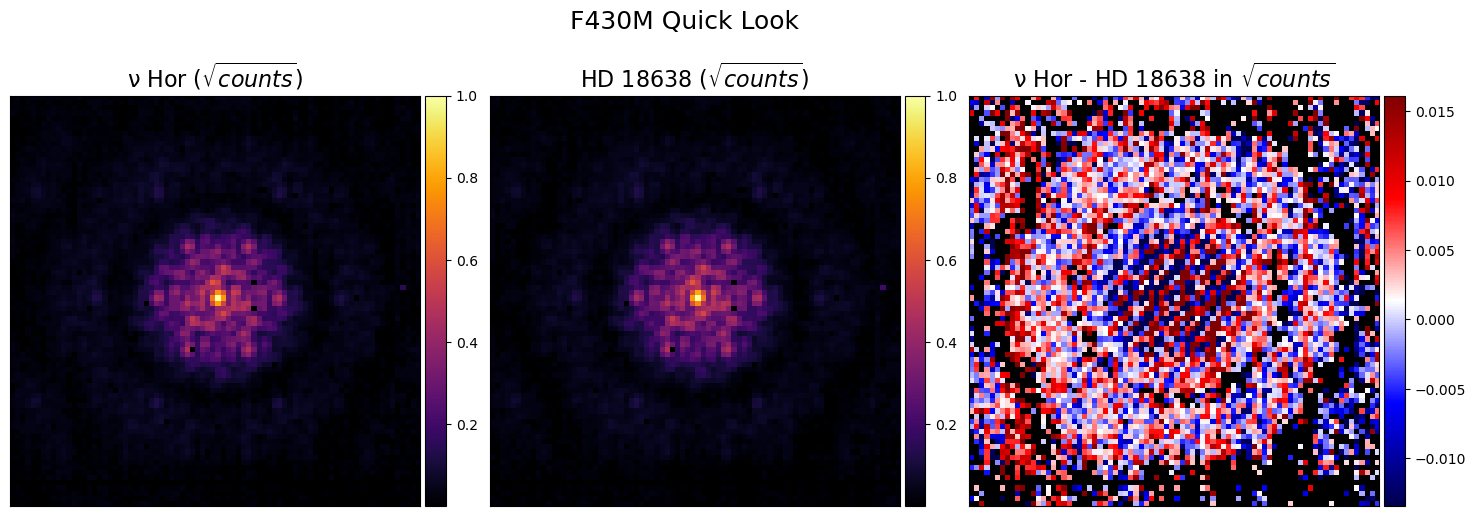

In [4]:
# plot all the F430M images

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,6))

# nu Hor

d = 'jw01242009001_03104_00001_nis/'
fname = glob(d + '*_nis_cal.fits')[0]
target_name = fits.getheader(fname)['TARGNAME'].strip('*').strip(' ').replace('.','').replace('nu', 'ν')
hdu = fits.open(fname)
data = 1.0* hdu[1].data
data = integer_recentre(data)

# saturated = threshold_mask(data,thresh=99.9,dilation=0)
# data[saturated] = np.nan

im = data/np.nanmax(data)
im = np.sqrt(im)

cmap = plt.cm.inferno
cmap.set_bad(color='k')

vmin, vmax = np.percentile(im[np.isfinite(im)], [0,100])
a = ax1.imshow(im, origin='lower', cmap=cmap,vmin=vmin, vmax=vmax)
ax1.set_title(r'%s ($\sqrt{counts}$)' % target_name,fontsize=16)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(a,cax=cax)

# disable ticks
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])

# HD 18638

d = 'jw01242010001_03104_00001_nis/'
fname2 = glob(d + '*_nis_cal.fits')[0]
target_name = fits.getheader(fname2)['TARGNAME']
hdu = fits.open(fname2)
data2 = 1.0*hdu[1].data
data2 = integer_recentre(data2)
# data2[saturated] = np.nan

m, b = linear_fit(data2, data)
data2 *= m

im2 = data2/np.nanmax(data2)
im2 = np.sqrt(im2)

# vmin, vmax = np.percentile(data2[np.isfinite(data2)], [0,100])
b = ax2.imshow(im2, origin='lower', cmap=cmap,vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)

ax2.set_title(r'%s ($\sqrt{counts}$)' % target_name,fontsize=16)

plt.colorbar(b,cax=cax)

ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])

# difference image

diff = im-im2
diff /= np.nanmax(im)

cmap2 = plt.cm.seismic
cmap2.set_bad(color='k')
vmin, vmax = np.percentile(diff[np.isfinite(diff)], [5,95])

c = ax3.imshow(diff, origin='lower', cmap=cmap2,vmin=vmin, vmax=vmax)
ax3.set_title('ν Hor - HD 18638 in $\sqrt{counts}$',fontsize=16)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(c,cax=cax)

ax3.xaxis.set_ticks([])
ax3.yaxis.set_ticks([])

plt.subplots_adjust(wspace=0.1)
plt.suptitle('F430M Quick Look',fontsize=18)

## Now do the FT at 430M

In [5]:
pscale = 65.57361 # arcsec/pixel

coords = np.meshgrid(np.arange(data.shape[0])-data.shape[0]//2,np.arange(data.shape[1])-data.shape[1]//2)
coords = np.array([coords[0]*pscale, coords[1]*pscale])

args = np.array(np.unravel_index(nanargmax(data), np.array(data).shape)[1])#[::-1]

nanmask = ~np.isnan(data-data2).flatten()

wavel = 4.3e-6
uvmax = 6 
uu, vv = np.meshgrid(np.linspace(-uvmax,uvmax,128), np.linspace(-uvmax,uvmax,128))
uv = np.vstack([uu.flatten(), vv.flatten()]).T

transform = UVNonUniform(uv,coords[0].flatten()[nanmask.flatten()],coords[1].flatten()[nanmask.flatten()],wavel)


I0000 00:00:1698907975.049410       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Text(0.5, 0.98, 'ν Hor F430M Fourier Transform')

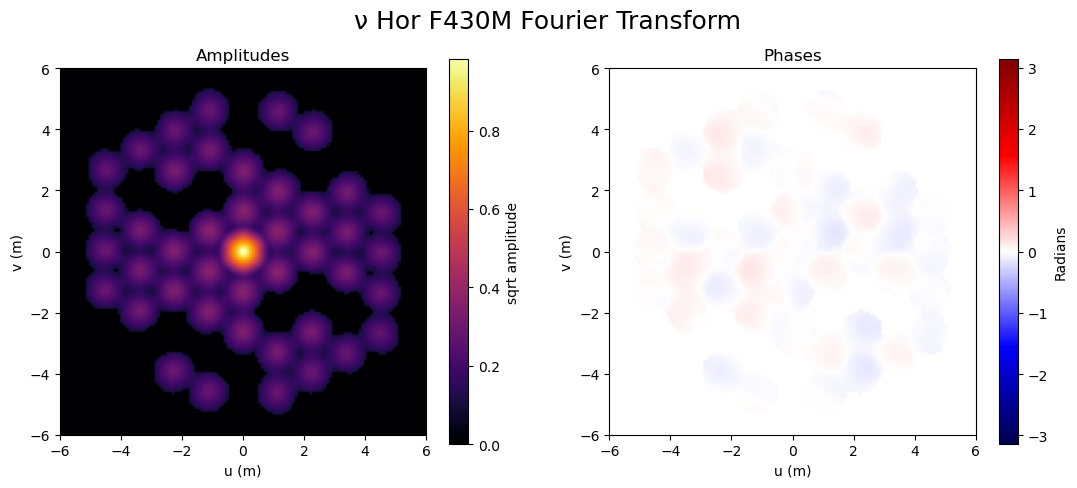

In [6]:
ft = transform(data.flatten()[nanmask]).reshape(uu.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps = np.abs(ft)
mask = amps/amps.max() > 0.01
amps[~mask] = 0

im1 = ax1.imshow(amps**0.5,
                 extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno',origin='lower')
fig.colorbar(im1, ax=ax1,label='sqrt amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')

alpha = ((amps-amps.min())/(amps.max()-amps.min()))**0.5

phases = np.angle(ft).copy()

c2 = ax2.imshow(phases,alpha=alpha, 
                 cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax],origin='lower')
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(c2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')

plt.suptitle('ν Hor F430M Fourier Transform',fontsize=18)

Text(0.5, 0.98, 'HD 18638 F430M Fourier Transform')

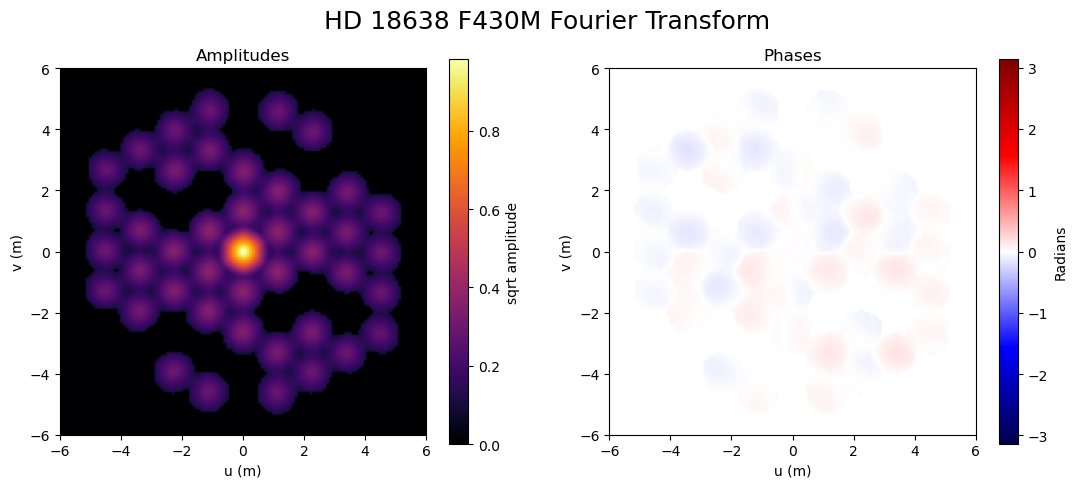

In [7]:
ft2 = transform(data2.flatten()[nanmask]).reshape(uu.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps = np.abs(ft2)
amps[~mask] = 0

im1 = ax1.imshow(amps**0.5,
                 extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno',origin='lower')
fig.colorbar(im1, ax=ax1,label='sqrt amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')



phases = np.angle(ft2).copy()

im2 = ax2.imshow(phases,alpha=((amps-amps.min())/(amps.max()-amps.min()))**0.5, 
                 cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax],origin='lower')
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(c2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')
plt.suptitle('HD 18638 F430M Fourier Transform',fontsize=18)


Text(0.5, 0.98, 'ν Hor / HD 18638 F430M Fourier Transform')

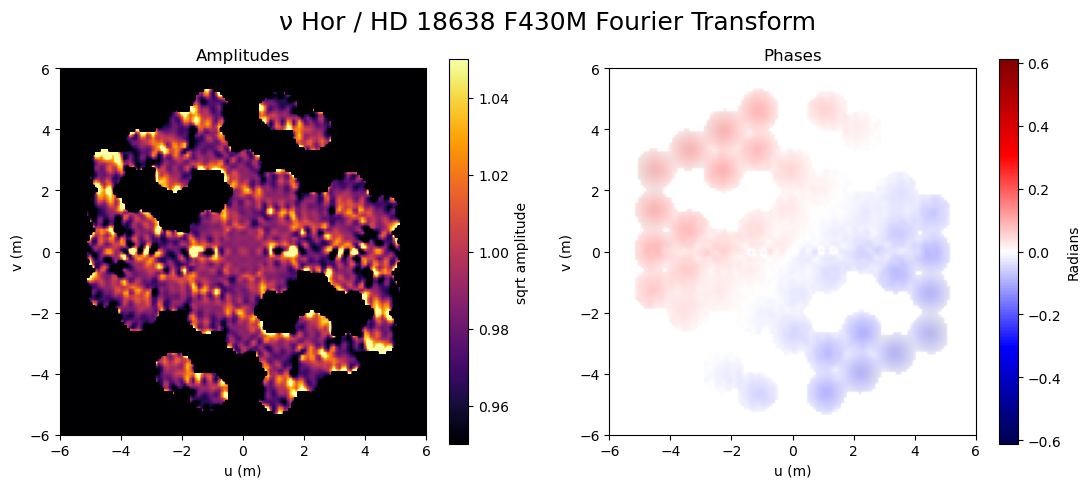

In [8]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps = np.abs(ft)/np.abs(ft2)

amps[~mask] = 0


im1 = ax1.imshow(amps,
                 extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno',origin='lower',
                 vmin=0.95,vmax=1.05)
fig.colorbar(im1, ax=ax1,label='sqrt amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')



phases = np.angle(ft).copy()-np.angle(ft2).copy()
phases[~mask] = 0
c2 = ax2.imshow(phases,alpha=alpha, 
                 cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax],origin='lower',)
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(c2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')

plt.suptitle('ν Hor / HD 18638 F430M Fourier Transform',fontsize=18)

# Now do F480M

/var/folders/vx/lm_q_1ld7c13_fbqfscs9n4w0000gq/T/ipykernel_88518/2493979992.py:18: RuntimeWarning: invalid value encountered in sqrt
  im = np.sqrt(data)
/var/folders/vx/lm_q_1ld7c13_fbqfscs9n4w0000gq/T/ipykernel_88518/2493979992.py:49: RuntimeWarning: invalid value encountered in sqrt
  im2 = np.sqrt(data2)


Text(0.5, 0.98, 'F480M Quick Look')

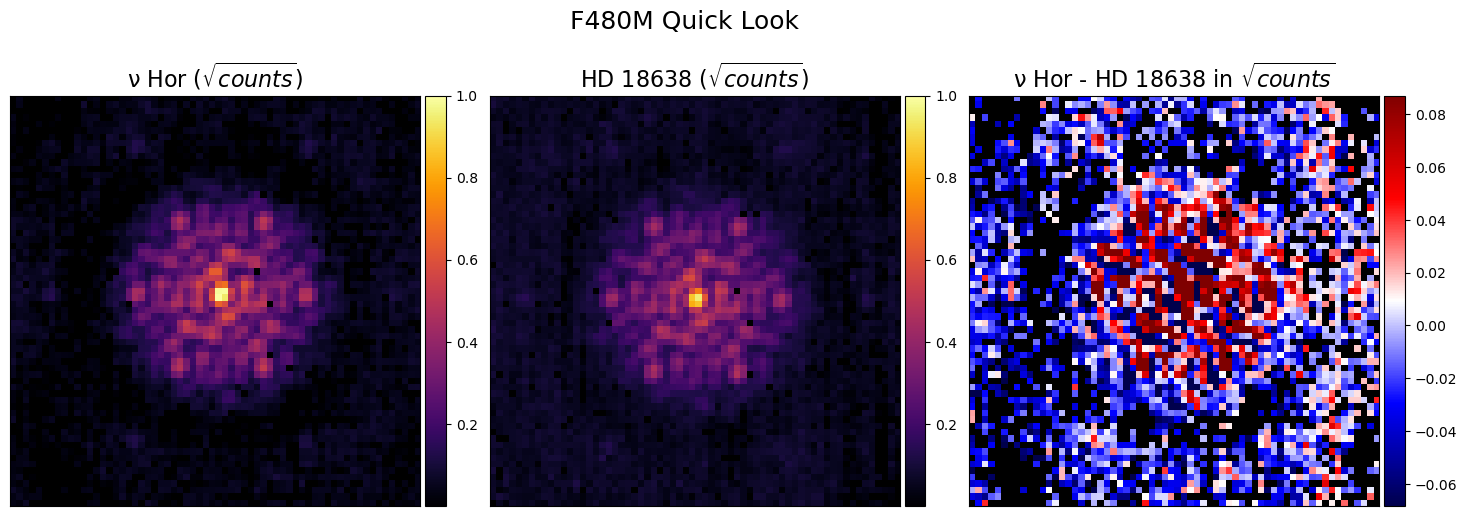

In [9]:
# plot all the F430M images

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,6))

# nu Hor

d = 'jw01242009001_02101_00001_nis/'
fname = glob(d + '*_nis_cal.fits')[0]
target_name = fits.getheader(fname)['TARGNAME'].strip('*').strip(' ').replace('.','').replace('nu', 'ν')
hdu = fits.open(fname)
data = 1.0*hdu[1].data
data = integer_recentre(data)
data /= np.nanmax(data)

# saturated = threshold_mask(data,thresh=99.9,dilation=0)
# data[saturated] = np.nan

im = np.sqrt(data)

cmap = plt.cm.inferno
cmap.set_bad(color='k')

vmin, vmax = np.percentile(im[np.isfinite(im)], [0,100])
a = ax1.imshow(im, origin='lower', cmap=cmap,vmin=vmin, vmax=vmax)
ax1.set_title(r'%s ($\sqrt{counts}$)' % target_name,fontsize=16)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(a,cax=cax)

# disable ticks
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])

# HD 18638

d = 'jw01242010001_02101_00001_nis/'
fname2 = glob(d + '*_nis_cal.fits')[0]
target_name = fits.getheader(fname2)['TARGNAME']
hdu = fits.open(fname2)
data2 = 1.0*hdu[1].data
data2 = integer_recentre(data2)
data2 /= np.nanmax(data2)
# data2[saturated] = np.nan
m, b = linear_fit(data2, data)
data2 = data2*m #+ b


im2 = np.sqrt(data2)

# vmin, vmax = np.percentile(data2[np.isfinite(data2)], [0,100])
b = ax2.imshow(im2, origin='lower', cmap=cmap,vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)

ax2.set_title(r'%s ($\sqrt{counts}$)' % target_name,fontsize=16)

plt.colorbar(b,cax=cax)

ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])

# difference image

diff = im - im2
diff /= np.nanmax(im)

cmap2 = plt.cm.seismic
cmap2.set_bad(color='k')
vmin, vmax = np.percentile(diff[np.isfinite(diff)], [5,95])

c = ax3.imshow(diff, origin='lower', cmap=cmap2,vmin=vmin, vmax=vmax)
ax3.set_title('ν Hor - HD 18638 in $\sqrt{counts}$',fontsize=16)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(c,cax=cax)

ax3.xaxis.set_ticks([])
ax3.yaxis.set_ticks([])

plt.subplots_adjust(wspace=0.1)
plt.suptitle('F480M Quick Look',fontsize=18)

In [10]:
pscale = 65.55983 # arcsec/pixel

coords = np.meshgrid(np.arange(data.shape[0])-data.shape[0]//2,np.arange(data.shape[1])-data.shape[0]//2)
coords = np.array([coords[0]*pscale, coords[1]*pscale])

args = np.array(np.unravel_index(nanargmax(data), np.array(data).shape)[1])#[::-1]

nanmask = ~np.isnan(data-data2).flatten()

wavel = 4.8e-6
uvmax = 6 
uu, vv = np.meshgrid(np.linspace(-uvmax,uvmax,128), np.linspace(-uvmax,uvmax,128))
uv = np.vstack([uu.flatten(), vv.flatten()]).T

transform = UVNonUniform(uv,coords[0].flatten()[nanmask.flatten()],coords[1].flatten()[nanmask.flatten()],wavel)


Text(0.5, 0.98, 'ν Hor F480M Fourier Transform')

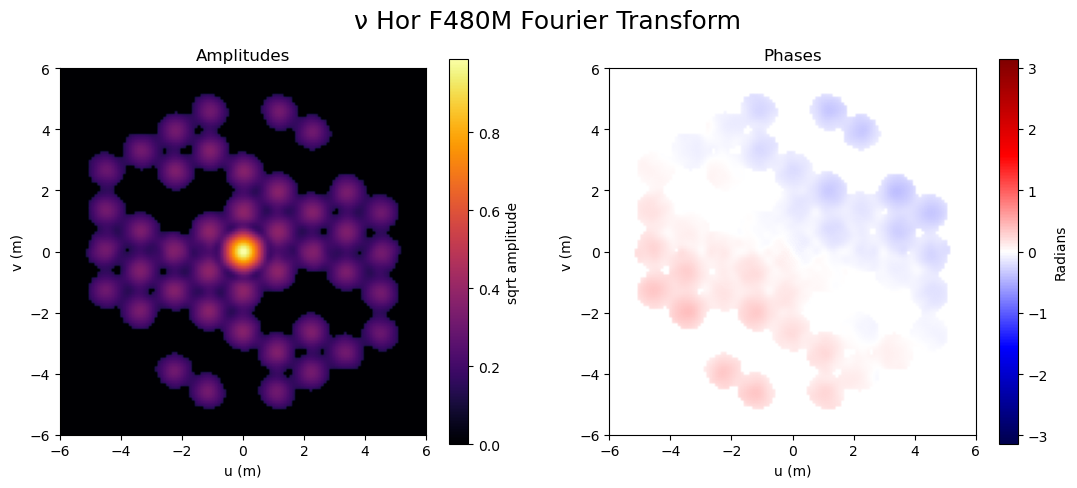

In [11]:
ft = transform(data.flatten()[nanmask]).reshape(uu.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps = np.abs(ft)
mask = amps/amps.max() > 0.02
amps[~mask] = 0

im1 = ax1.imshow(amps**0.5,
                 extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno',origin='lower')
fig.colorbar(im1, ax=ax1,label='sqrt amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')

alpha = ((amps-amps.min())/(amps.max()-amps.min()))**0.5

phases = np.angle(ft).copy()

im2 = ax2.imshow(phases,alpha=alpha, 
                 cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax],origin='lower')
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(im2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')

plt.suptitle('ν Hor F480M Fourier Transform',fontsize=18)

Text(0.5, 0.98, 'HD 18638 F480M Fourier Transform')

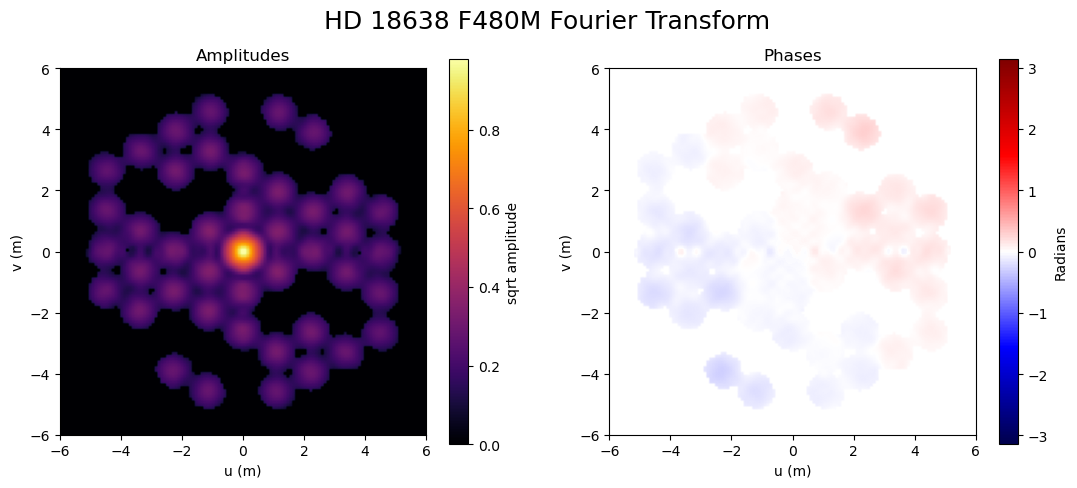

In [12]:
ft2 = transform(data2.flatten()[nanmask]).reshape(uu.shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps = np.abs(ft2)

amps[~mask] = 0

im1 = ax1.imshow(amps**0.5,
                 extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno',origin='lower')
fig.colorbar(im1, ax=ax1,label='sqrt amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')



phases = np.angle(ft2).copy()

im2 = ax2.imshow(phases,alpha=((amps-amps.min())/(amps.max()-amps.min()))**0.5, 
                 cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax],origin='lower')
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(im2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')
plt.suptitle('HD 18638 F480M Fourier Transform',fontsize=18)


Text(0.5, 0.98, 'ν Hor / HD 18638 F480M Fourier Transform')

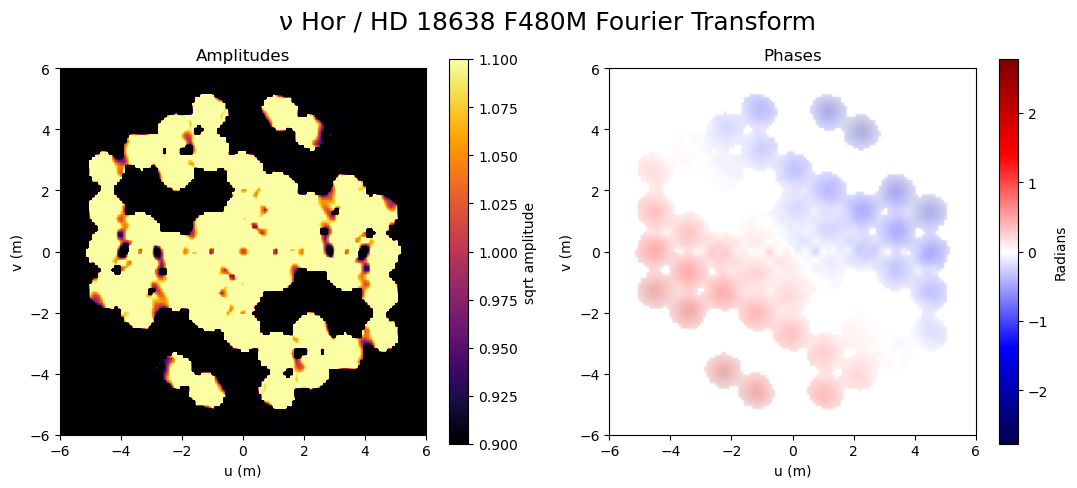

In [13]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

amps = np.abs(ft)/np.abs(ft2)
amps[~mask] = 0


im1 = ax1.imshow(amps,
                 extent=[-uvmax,uvmax,-uvmax,uvmax],cmap='inferno',origin='lower',
                 vmin=0.9,vmax=1.1)
fig.colorbar(im1, ax=ax1,label='sqrt amplitude')
ax1.set_title('Amplitudes')
ax1.set_xlabel('u (m)')
ax1.set_ylabel('v (m)')



phases = np.angle(ft).copy()-np.angle(ft2).copy()
phases[~mask] = 0
im2 = ax2.imshow(phases,alpha=alpha, 
                 cmap='seismic',extent=[-uvmax,uvmax,-uvmax,uvmax],origin='lower')
ax2.set_title('Phases')
# add a colorbar to ax2
fig.colorbar(im2, ax=ax2,label='Radians')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')

plt.suptitle('ν Hor / HD 18638 F480M Fourier Transform',fontsize=18)